In [1]:
# 계산
import numpy as np

# 전처리
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# 평가
from sklearn.metrics import mean_squared_error

# 모델링
import lightgbm as lgb

from sklearn import tree

# 출력 및 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from tqdm.auto import tqdm

# 데이터셋 로드 및 정제
import pandas as pd
import itertools
import json
import joblib

# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore')

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

In [2]:
# dt = pd.read_csv('../data_process/house_select.csv')
# dt = pd.read_csv('../data_process/house_markets.csv')
dt = pd.read_csv('../data_process/house_outlier.csv')

In [3]:
dt.shape

(1125968, 49)

In [4]:
dt.columns

Index(['본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'target',
       'is_test', '주소', 'X', 'Y', '1_bus', '3_bus', '5_bus', '10_bus', '1_sub',
       '3_sub', '5_sub', '10_sub', '1_school', '3_school', '5_school',
       '10_school', 'bus_access_score', 'sub_access_score',
       'school_access_score', '계약연도', '계약월', '구', '동', '아파트_최고층', '층_최고층대비비율',
       '층구간_상대', '구_해당달_거래수', '동_해당달_거래수', '구_직전달까지누적거래수', '동_직전달까지누적거래수',
       '동대구_해당달_비율', '동대구_직전누적_비율', '연식', '연식_bin', '강남여부', '브랜드',
       'market_score_1000m', 'market_score_3000m', 'market_score_5000m'],
      dtype='object')

In [5]:
dt.isna().sum()

본번                       75
부번                       75
아파트명                     10
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
target                 9272
is_test                   0
주소                        0
X                         0
Y                         0
1_bus                     0
3_bus                     0
5_bus                     0
10_bus                    0
1_sub                     0
3_sub                     0
5_sub                     0
10_sub                    0
1_school                  0
3_school                  0
5_school                  0
10_school                 0
bus_access_score          0
sub_access_score          0
school_access_score       0
계약연도                      0
계약월                       0
구                         0
동                         0
아파트_최고층                  10
층_최고층대비비율                 0
층구간_상대              

In [6]:
dt[['본번', '부번', '아파트_최고층', '아파트명']] = dt[['본번', '부번', '아파트_최고층', '아파트명']].interpolate()
#dt = dt.dropna(subset=['아파트명'])

In [7]:
dt.isna().sum()

본번                        0
부번                        0
아파트명                     10
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
target                 9272
is_test                   0
주소                        0
X                         0
Y                         0
1_bus                     0
3_bus                     0
5_bus                     0
10_bus                    0
1_sub                     0
3_sub                     0
5_sub                     0
10_sub                    0
1_school                  0
3_school                  0
5_school                  0
10_school                 0
bus_access_score          0
sub_access_score          0
school_access_score       0
계약연도                      0
계약월                       0
구                         0
동                         0
아파트_최고층                   0
층_최고층대비비율                 0
층구간_상대              

In [8]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in dt.columns:
    if pd.api.types.is_numeric_dtype(dt[column]) and dt[column].dtype != bool:
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

# 범주형 변수에 대한 보간
dt[categorical_columns] = dt[categorical_columns].fillna('NULL')

연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test', 'X', 'Y', '1_bus', '3_bus', '5_bus', '10_bus', '1_sub', '3_sub', '5_sub', '10_sub', '1_school', '3_school', '5_school', '10_school', 'bus_access_score', 'sub_access_score', 'school_access_score', '계약연도', '계약월', '아파트_최고층', '층_최고층대비비율', '구_해당달_거래수', '동_해당달_거래수', '구_직전달까지누적거래수', '동_직전달까지누적거래수', '동대구_해당달_비율', '동대구_직전누적_비율', '연식', '강남여부', 'market_score_1000m', 'market_score_3000m', 'market_score_5000m']
범주형 변수: ['아파트명', '도로명', '주소', '구', '동', '층구간_상대', '연식_bin', '브랜드']


In [9]:
#인코딩
label_encoder = LabelEncoder()
for i in categorical_columns:
    dt[i] = label_encoder.fit_transform(dt[i])

In [10]:
# Train/Test 분리 후 저장: Train에는 target_log_clip만 포함
train = dt[dt['is_test'] == 0]
test  = dt[dt['is_test'] == 1]

In [11]:
# 범주형 컬럼 자동 탐지 + 명시적 범주형 포함
auto_cats = train.select_dtypes(include=['object', 'category']).columns.tolist()
explicit_cats = ['연식_bin', '층구간_상대', '브랜드', '아파트명', '도로명', '주소', '구', '동', 'area_bin_in_region']
cat_cols = [c for c in (set(auto_cats) | set(explicit_cats)) if c in train.columns]
# Train/Test 합쳐 카테고리 정합
if len(cat_cols) > 0:
    concat = pd.concat([train[cat_cols], test[cat_cols]], axis=0, ignore_index=True)
    for c in cat_cols:
        concat[c] = concat[c].astype('category')
    for c in cat_cols:
        train[c] = pd.Categorical(train[c], categories=concat[c].cat.categories)
        test[c]  = pd.Categorical(test[c],  categories=concat[c].cat.categories)
# 피처/타깃 분리 (is_test는 정보량이 없으므로 제거)
drop_cols = ['target']
if 'is_test' in train.columns:
    drop_cols.append('is_test')
X = train.drop(columns=drop_cols)
y = train['target'].astype(float)
X_test = test.drop(columns=['is_test']) if 'is_test' in test.columns else test.copy()

In [12]:
# Target과 독립변수들을 분리해줍니다.
y_train = train['target']
X_train = train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [13]:
X_train.isna().sum()

본번                     0
부번                     0
아파트명                   0
전용면적                   0
계약년월                   0
계약일                    0
층                      0
건축년도                   0
도로명                    0
is_test                0
주소                     0
X                      0
Y                      0
1_bus                  0
3_bus                  0
5_bus                  0
10_bus                 0
1_sub                  0
3_sub                  0
5_sub                  0
10_sub                 0
1_school               0
3_school               0
5_school               0
10_school              0
bus_access_score       0
sub_access_score       0
school_access_score    0
계약연도                   0
계약월                    0
구                      0
동                      0
아파트_최고층                0
층_최고층대비비율              0
층구간_상대                 0
구_해당달_거래수              0
동_해당달_거래수              0
구_직전달까지누적거래수           0
동_직전달까지누적거래수           0
동대구_해당달_비율             0


In [14]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

# ✅ 1. 원래 컬럼명 저장해두기
original_columns = X_train.columns.tolist()

# ✅ 2. 컬럼명 f0, f1, ... 로 변경
X_train.columns = [f"f{i}" for i in range(X_train.shape[1])]
X_val.columns   = X_train.columns
#X_test.columns  = X_train.columns

# 매핑 딕셔너리 (나중에 Feature Importance 해석용)
feature_map = {f"f{i}": col for i, col in enumerate(original_columns)}

# ✅ 3. 모델 선언
model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    metric='rmse',
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

# ✅ 4. 학습
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.log_evaluation(period=20)]
)

# ✅ 5. 예측 및 평가
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RaMSE:", rmse)

# ✅ 6. Feature Importance 출력
importance = model.feature_importances_
for f, imp in sorted(zip(X_train.columns, importance), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{feature_map[f]} : {imp}")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24139
[LightGBM] [Info] Number of data points in the train set: 893356, number of used features: 47
[LightGBM] [Info] Start training from score 58069.236275
[20]	training's rmse: 23758.3	valid_1's rmse: 23707.3
[40]	training's rmse: 15255.5	valid_1's rmse: 15352.4
[60]	training's rmse: 11756.2	valid_1's rmse: 11944.8
[80]	training's rmse: 10076.6	valid_1's rmse: 10325
[100]	training's rmse: 9156.56	valid_1's rmse: 9440.12
[120]	training's rmse: 8549.25	valid_1's rmse: 8852.9
[140]	training's rmse: 8130.65	valid_1's rmse: 8471.24
[160]	training's rmse: 7830.9	valid_1's 

In [15]:
X_test = test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

In [16]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

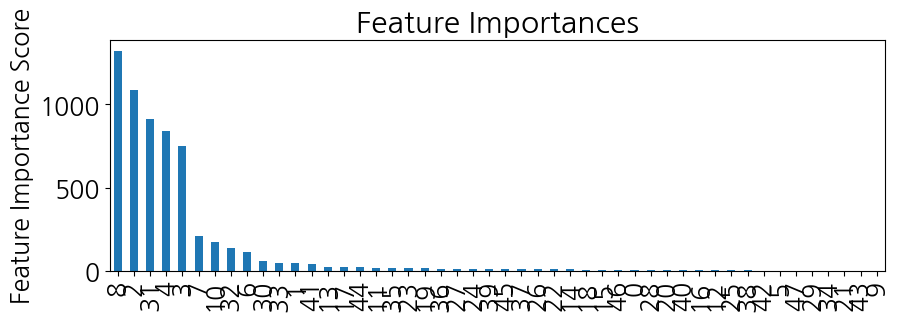

In [17]:
# 학습된 LGBM의 feature importance는 아래와 같습니다.
feat_imp = model.feature_importances_
sorted_feat_imp = pd.Series(feat_imp).sort_values(ascending=False)
plt.figure(figsize=(10,3))
sorted_feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

In [18]:
# 위 importance를 이용해 importance가 100 이상인 변수들만 학습에 이용하겠습니다.
from sklearn.feature_selection import SelectFromModel
import time

sfm = SelectFromModel(model, threshold=100, prefit = True)     # importance를 선정할 threshold를 설정합니다.
sfm.fit(X_train, y_train) # 훈련 데이터를 사용하여 중요한 특성을 선택합니다.
X_important_train = sfm.transform(X_train)
X_important_valid = sfm.transform(X_val)

start_time = time.time()
gbm = lgb.LGBMRegressor(n_estimators=100000,                # early stopping을 적용하기에 적당히 많은 반복 횟수를 지정합니다.
                        metric="rmse",
                        data_sample_strategy='goss',        # sampling 방법을 goss로 적용합니다.
                        max_depth=12,                       # default값인 20에서 12로 변경합니다.
                        num_leaves=62,                      # default값인 31에서 62으로 변경합니다.
                        min_data_in_leaf=40                 # default값인 20에서 40으로 변경합니다.
                        )

# 선택된 feature들로 재학습하겠습니다.
gbm.fit(X_important_train, y_train,
        eval_set=[(X_important_train, y_train), (X_important_valid, y_val)],
        eval_metric ='rmse',
        categorical_feature="auto",
        callbacks=[lgb.early_stopping(stopping_rounds=50),         # early stopping을 적용합니다. 50번동안 metirc의 개선이 없다면 학습을 중단합니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]  # 10번의 반복마다 평가점수를 로그에 나타냅니다.
)

y_pred = gbm.predict(X_important_valid)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"변수 선택 후 코드 실행 시간: {elapsed_time} 초")

# 제곱근 평균 제곱 오차 (RMSE) 계산
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RaMSE:", rmse)
print("변수 선택 후 RMSE:", rmse)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 893356, number of used features: 9
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Start training from score 58069.236275
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 25941.8	valid_1's rmse: 25948.4
[20]	training's rmse: 18818.8	valid_1's rmse: 18916.7
[30]	training's rmse: 1

In [19]:
X_test = test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output2.csv', index=False)

In [20]:
import joblib

# 저장
joblib.dump(gbm, "lgb_model.pkl")

# # 불러오기
# gbm_loaded = joblib.load("lgb_model.pkl")

# # 예측
# y_pred = gbm_loaded.predict(X_important_valid)

['lgb_model.pkl']